# 0. About

This notebook is to try to build up an estimator, i.e. `sklearn.base.BaseEstimator`, with Kernel CCA.
The main benefit is to improve the computing speed when applying `GridSearch` for the hyperparameters searching.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import scipy
import warnings
import time
from tqdm.notebook import tqdm

import sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.model_selection import RepeatedKFold, GridSearchCV, ParameterGrid
from sklearn.utils import Bunch, check_array
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import rbf_kernel, euclidean_distances, pairwise_kernels

from kcca import TwoViewKCCA

rs_num = 42
rng = np.random.default_rng(rs_num)

sklearn.set_config(display="diagram")

n_splits = 5
n_repeats = 20

%matplotlib inline

# 1. Dataset Construction

In [2]:
sample_num = 200
X_dimension_num = 6
Y_dimension_num = 8

# construct X
X = rng.normal(loc=0.5, scale=1.0, size=(sample_num, X_dimension_num))

# construct noise
delta_1 = rng.normal(loc=0.0, scale=0.03, size=(sample_num, ))
delta_2 = rng.normal(loc=0.0, scale=0.02, size=(sample_num, ))
delta_3 = rng.normal(loc=0.0, scale=0.01, size=(sample_num, ))

# construct Y
Y = rng.normal(loc=0.3, scale=1.0, size=(sample_num, Y_dimension_num))
Y[:, 0] = np.exp(X[:, 3]) + delta_1
Y[:, 1] = np.power(X[:, 0], 2) + delta_2
Y[:, 2] = np.power(X[:, 1], -1) + delta_3

In [3]:
# split dataset into training and testing
[X_train, X_test, Y_train, Y_test] = train_test_split(
    X, Y, test_size=0.20, random_state=rs_num
)

Standardize datasets based on the training datasets.

In [4]:
scaler_x = StandardScaler().fit(X_train)
scaler_y = StandardScaler().fit(Y_train)
X_train = scaler_x.transform(X_train)
Y_train = scaler_y.transform(Y_train)
X_test = scaler_x.transform(X_test)
Y_test = scaler_y.transform(Y_test)

# 2. Solve KCCA via Manual Computation

## 2.1. Find Gamma Parameters for RBF Kernel

In [5]:
def find_sigma_n_gamma(M):
    # matrix M should be in the shape of (sample_num, feature_num)
    # note: the `scipy.spatial.distance.pdist` will provide different results, 
    # compared to the `sklearn.metrics.pairwise.euclidean_distances`
    
#     sigma = np.median(scipy.spatial.distance.pdist(M, metric='euclidean'))
    sigma = np.median(euclidean_distances(M).flatten())
    gamma = 1.0/(2.0*sigma**2)
    
    return [sigma, gamma]

In [6]:
[sigma_x, gamma_x] = find_sigma_n_gamma(X_train)
[sigma_y, gamma_y] = find_sigma_n_gamma(Y_train)

## 2.2. Test out the Manual Computation

In [7]:
def kernel_computing(
    a, b, kernel_name='linear', 
    gamma=1.0, degree=1.0, coef0=0.0
):
    params = {
        'gamma': gamma, 
        'degree': degree, 
        'coef0': coef0
    }
    return pairwise_kernels(
        a, b, metric=kernel_name, 
        filter_params=True, **params
    )

In [8]:
def kcca_fit_n_score(
    X_train, X_test, Y_train, Y_test, n_components=1, 
    c_x=1.0, c_y=1.0, gamma_x=1.0, gamma_y=1.0, 
    degree_x=1.0, degree_y=1.0, coef0_x=0.0, coef0_y=0.0, 
    kernel_name='linear', random_state=None, standardization=True
):
    if standardization:
        scaler_x = StandardScaler().fit(X_train)
        scaler_y = StandardScaler().fit(Y_train)
        X_train = scaler_x.transform(X_train)
        Y_train = scaler_y.transform(Y_train)
        X_test = scaler_x.transform(X_test)
        Y_test = scaler_y.transform(Y_test)
    
    n_sample_train = X_train.shape[0]
    
    # compute for K matrices
    Kx_train = kernel_computing(
        X_train, X_train, 
        kernel_name=kernel_name, 
        gamma=gamma_x, degree=degree_x, coef0=coef0_x
    )
    Ky_train = kernel_computing(
        Y_train, Y_train, 
        kernel_name=kernel_name, 
        gamma=gamma_y, degree=degree_y, coef0=coef0_y
    )
    Kxy_train = Kx_train.dot(Ky_train)
    
    A = np.zeros((2*n_sample_train, 2*n_sample_train))
    A[:n_sample_train, n_sample_train:] = Kxy_train
    A[n_sample_train:, :n_sample_train] = Kxy_train.T
    
    B = np.zeros_like(A)
    B[:n_sample_train, :n_sample_train] = np.linalg.matrix_power(
        Kx_train + c_x * np.eye(n_sample_train), 2
    )
    B[n_sample_train:, n_sample_train:] = np.linalg.matrix_power(
        Ky_train + c_y * np.eye(n_sample_train), 2
    )
    
    # solve for generalized eigenvalue problem
    [eig_val_output, eig_vec_output] = scipy.linalg.eigh(A, B)
    
    # slicing arrays
    eig_val = eig_val_output[eig_val_output>=0.0]
    eig_vec = eig_vec_output[:, eig_val_output>=0.0]
    
    # sort based on eigenvalues, descending order
    sort_ind_des = eig_val.argsort()[::-1]
    eig_val = eig_val[sort_ind_des]
    eig_vec = eig_vec[:, sort_ind_des]
    
    alpha = eig_vec[:n_sample_train, :n_components]
    beta = eig_vec[n_sample_train:, :n_components]
    
    # map the test dataset
    Kx_test = kernel_computing(
        X_test, X_train, kernel_name=kernel_name, 
        gamma=gamma_x, degree=degree_x, coef0=coef0_x
    )
    Ky_test = kernel_computing(
        Y_test, Y_train, kernel_name=kernel_name, 
        gamma=gamma_y, degree=degree_y, coef0=coef0_y
    )
    
    # score on test datasets
    zx_test = Kx_test.dot(alpha)
    zy_test = Ky_test.dot(beta)
    if n_components == 1:
        score = cosine_similarity(
            zx_test.reshape(1, -1), 
            zy_test.reshape(1, -1)
        )[0][0]
    else:
        score = np.diag(
            cosine_similarity(zx_test.T, zy_test.T)
        )
    return score

In [9]:
manual_kcca_bunch = Bunch()
manual_kcca_bunch.name = 'manual KCCA'

In [10]:
def create_test_env(X, Y, n_components, gamma_x, gamma_y, random_state):
    c_x = 1.0
    c_y = 1.0
    kernel_name = 'rbf'
    standardization = True
    
    # split the datasets
    [X_train, X_test, Y_train, Y_test] = train_test_split(
        X, Y, test_size=0.20, random_state=random_state
    )
    
    test_datasets = {
        'X_train': X_train, 'X_test': X_test, 
        'Y_train': Y_train, 'Y_test': Y_test
    }
    
    test_params = {
        'n_components': n_components, 'c_x': c_x, 'c_y': c_y, 
        'gamma_x': gamma_x, 'gamma_y':gamma_y, 
        'kernel_name': kernel_name, 'random_state': random_state, 
        'standardization': standardization
    }
    
    return [test_datasets, test_params]

In [11]:
# set up the test parameters
n_components = 3
test_datasets, test_params = create_test_env(
    X_train, Y_train, n_components, gamma_x, gamma_y, rs_num
)

In [12]:
manual_kcca_bunch.sample_test_score_arr = kcca_fit_n_score(**{**test_datasets, **test_params})

print('For the test parameters, the canonical correlation on the test datasets are:')
print(manual_kcca_bunch.sample_test_score_arr)

For the test parameters, the canonical correlation on the test datasets are:
[0.98544208 0.86502254 0.61143248]


## 2.3. Find Optimal Regularization Parameters

In [13]:
def custom_cv(validator, X, Y, fit_n_score_func, *args, **kwargs):
    # note: normally X and Y are already training datasets
    
    # construct score array
    score_arr = np.zeros((validator.get_n_splits(), ))
    
    # fit and validate
    ii = 0
    
    for train_ind, test_ind in validator.split(X):
        # slicing arrays
        X_train, X_test = X[train_ind], X[test_ind]
        Y_train, Y_test = Y[train_ind], Y[test_ind]
        
        # train the model and get the score
        score_arr[ii] = fit_n_score_func(X_train, X_test, Y_train, Y_test, *args, **kwargs)
        ii += 1
    
    return score_arr

In [14]:
def kcca_fit_n_score_mean(X_train, X_test, Y_train, Y_test, *args, **kwargs):
    score = kcca_fit_n_score(
        X_train, X_test, Y_train, Y_test, *args, **kwargs
    )
    return np.nanmean(score)

In [15]:
manual_kcca_bunch.c_x_arr = 1.618*np.logspace(-10, -7, 15)
manual_kcca_bunch.c_y_arr = 3.142*np.logspace(-11, -8, 15)
manual_kcca_bunch.n_components = 3
manual_kcca_bunch.gamma_x = gamma_x
manual_kcca_bunch.gamma_y = gamma_y
manual_kcca_bunch.kernel_name = 'rbf'
manual_kcca_bunch.standardization = True

manual_kcca_bunch.score_arr_all = np.zeros((
    manual_kcca_bunch.c_x_arr.size, 
    manual_kcca_bunch.c_y_arr.size, 
    n_repeats*n_splits
))

# starting of the track of computing time
manual_kcca_bunch.t_start = time.time()

# ignore warnings for some bad searching
warnings.filterwarnings('ignore')

for c_x_i, c_x in enumerate(tqdm(manual_kcca_bunch.c_x_arr)):
    for c_y_i, c_y in enumerate(manual_kcca_bunch.c_y_arr):
        manual_kcca_bunch.score_arr_all[c_x_i, c_y_i, :] = custom_cv(
            RepeatedKFold(
                n_splits=n_splits, 
                n_repeats=n_repeats, 
                random_state=rs_num
            ),
            X_train, Y_train, 
            kcca_fit_n_score_mean, 
            n_components=manual_kcca_bunch.n_components, 
            c_x=c_x, 
            c_y=c_y, 
            gamma_x=manual_kcca_bunch.gamma_x, 
            gamma_y=manual_kcca_bunch.gamma_y, 
            kernel_name=manual_kcca_bunch.kernel_name, 
            random_state=rs_num, 
            standardization=manual_kcca_bunch.standardization
        )

manual_kcca_bunch.score_arr = np.nanmean(manual_kcca_bunch.score_arr_all, 2)

# reset warnings
warnings.resetwarnings()

# ending of the track of computing time
manual_kcca_bunch.t_elapsed = time.time() - manual_kcca_bunch.t_start

  0%|          | 0/15 [00:00<?, ?it/s]

In [16]:
print('Above cell computation takes {:.1f} seconds.'.format(manual_kcca_bunch.t_elapsed))

Above cell computation takes 223.2 seconds.


In [17]:
argmax_ind = np.unravel_index(
    manual_kcca_bunch.score_arr.argmax(), 
    np.array(manual_kcca_bunch.score_arr).shape
)
manual_kcca_bunch.c_x_opt = manual_kcca_bunch.c_x_arr[argmax_ind[0]]
manual_kcca_bunch.c_y_opt = manual_kcca_bunch.c_y_arr[argmax_ind[1]]
print('The c_x optimal is {:.2e} and the c_y optimal is {:.2e}'.format(
    manual_kcca_bunch.c_x_opt, 
    manual_kcca_bunch.c_y_opt
))

The c_x optimal is 8.38e-09 and the c_y optimal is 2.67e-09


## 2.4. Optimal Parameters Visualization

In [18]:
# visualization of c_x, c_y searching
def viz_cxcy_search(
    fig, ax, viz_x, viz_y, viz_color, n_repeats, n_splits, c_x_opt, c_y_opt
):
    sc = ax.scatter(
        viz_x, viz_y, c=viz_color, s=5
    )
    cbar = fig.colorbar(sc, ax=ax)
    cbar.set_label('Mean Test Score (Canonical Correlation)')
    ax.scatter(
        c_x_opt, 
        c_y_opt, 
        marker='o',
        ec='royalblue', 
        fc='none', 
        label='optimal'
    )

    ax.set(
        xlabel='$c_x$', 
        ylabel='$c_y$', 
        title=(
            'Grid Search with {}-repeat {}-fold CV'.format(n_repeats, n_splits) + 
            '\nfor Optimal Regularization Parameters'
        )
    )
    ax.legend(
        loc='upper center',
        bbox_to_anchor=(0.5, -0.15),
        fancybox=True,
        shadow=True,
        ncol=1,
        fontsize='small'
    )

In [20]:
# re-arrange arrays for visualization
manual_kcca_bunch.viz_x = np.zeros((manual_kcca_bunch.score_arr.size, ))
manual_kcca_bunch.viz_y = np.zeros_like(manual_kcca_bunch.viz_x)
manual_kcca_bunch.viz_color = np.zeros_like(manual_kcca_bunch.viz_x)

ind_viz = 0
for c_x_i, c_x in enumerate(manual_kcca_bunch.c_x_arr):
    for c_y_i, c_y in enumerate(manual_kcca_bunch.c_y_arr):
        manual_kcca_bunch.viz_x[ind_viz] = c_x
        manual_kcca_bunch.viz_y[ind_viz] = c_y
        manual_kcca_bunch.viz_color[ind_viz] = manual_kcca_bunch.score_arr[c_x_i, c_y_i]
        ind_viz += 1

The c_x optimal is 8.38e-09 and the c_y optimal is 2.67e-09


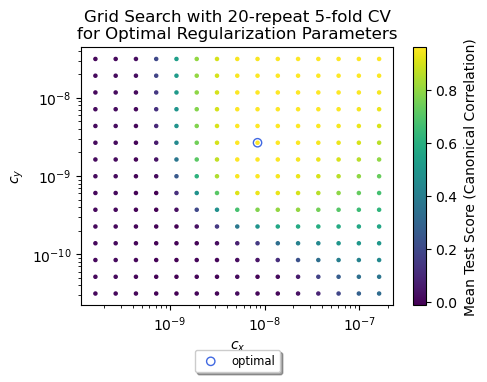

In [21]:
fig, ax = plt.subplots(figsize=(5, 4))

viz_cxcy_search(
    fig, ax, manual_kcca_bunch.viz_x, manual_kcca_bunch.viz_y, 
    manual_kcca_bunch.viz_color, n_repeats, n_splits, 
    manual_kcca_bunch.c_x_opt, manual_kcca_bunch.c_y_opt
)

ax.set(xscale='log', yscale='log')

fig.tight_layout()

print('The c_x optimal is {:.2e} and the c_y optimal is {:.2e}'.format(
    manual_kcca_bunch.c_x_opt, 
    manual_kcca_bunch.c_y_opt
))

# 3. Solve KCCA with the Estimator

## 3.1. Test the Estimator with the Test Environment

In [22]:
estimator_kcca_bunch = Bunch()
estimator_kcca_bunch.name = 'Estimator KCCA'

estimator_kcca_bunch.sample_test_score_arr = TwoViewKCCA(**test_params).fit(
    test_datasets['X_train'], test_datasets['Y_train']
).score(
    test_datasets['X_test'], test_datasets['Y_test']
)

print('For the estimator KCCA:')
print('For the test parameters, the canonical correlation on the test datasets are:')
print(estimator_kcca_bunch.sample_test_score_arr)

print()
print('For manual KCCA:')
print('For the test parameters, the canonical correlation on the test datasets are:')
print(manual_kcca_bunch.sample_test_score_arr)

For the estimator KCCA:
For the test parameters, the canonical correlation on the test datasets are:
[0.98544208 0.86502254 0.61143248]

For manual KCCA:
For the test parameters, the canonical correlation on the test datasets are:
[0.98544208 0.86502254 0.61143248]


They matched nicely!

## 3.2. Search for Optimal Regularization Parameters

In [23]:
def estimator_kcca_score_func_mean(estimator, X, y):
    score = estimator.score(X, y)
    return np.nanmean(score)

In [24]:
# set up parameters
estimator_kcca_bunch.n_components = manual_kcca_bunch.n_components
estimator_kcca_bunch.gamma_x = gamma_x
estimator_kcca_bunch.gamma_y = gamma_y
estimator_kcca_bunch.kernel_name = manual_kcca_bunch.kernel_name
estimator_kcca_bunch.standardization = manual_kcca_bunch.standardization
estimator_kcca_bunch.rkf = RepeatedKFold(
    n_splits=n_splits, n_repeats=n_repeats, random_state=rs_num
)

# set up the parameter grid
estimator_kcca_bunch.param_grid = {
    'c_x': manual_kcca_bunch.c_x_arr, 
    'c_y': manual_kcca_bunch.c_y_arr
}

In [25]:
# starting of the track of computing time
estimator_kcca_bunch.t_start = time.time()

# ignore warnings for some bad searching
warnings.filterwarnings('ignore')

estimator_kcca_bunch.gscv = GridSearchCV(
    TwoViewKCCA(
        n_components=estimator_kcca_bunch.n_components, 
        kernel_name=estimator_kcca_bunch.kernel_name, 
        gamma_x=estimator_kcca_bunch.gamma_x, 
        gamma_y=estimator_kcca_bunch.gamma_y, 
        random_state=rs_num, 
        standardization=estimator_kcca_bunch.standardization
    ), 
    param_grid=estimator_kcca_bunch.param_grid, 
    scoring=estimator_kcca_score_func_mean, 
    cv=estimator_kcca_bunch.rkf, 
    n_jobs=-1
).fit(X_train, Y_train)

# reset warnings
warnings.resetwarnings()

# ending of the track of computing time
estimator_kcca_bunch.t_elapsed = time.time() - estimator_kcca_bunch.t_start

In [26]:
print('Above cell computation takes {:.1f} seconds.'.format(estimator_kcca_bunch.t_elapsed))

Above cell computation takes 86.2 seconds.


In [27]:
# re-arrange arrays for visualization
estimator_kcca_bunch.viz_x = estimator_kcca_bunch.gscv.cv_results_['param_c_x'].data
estimator_kcca_bunch.viz_y = estimator_kcca_bunch.gscv.cv_results_['param_c_y'].data
estimator_kcca_bunch.viz_color = estimator_kcca_bunch.gscv.cv_results_['mean_test_score']
estimator_kcca_bunch.c_x_opt = estimator_kcca_bunch.gscv.best_params_['c_x']
estimator_kcca_bunch.c_y_opt = estimator_kcca_bunch.gscv.best_params_['c_y']

The c_x optimal is 1.37e-08 and the c_y optimal is 4.37e-09


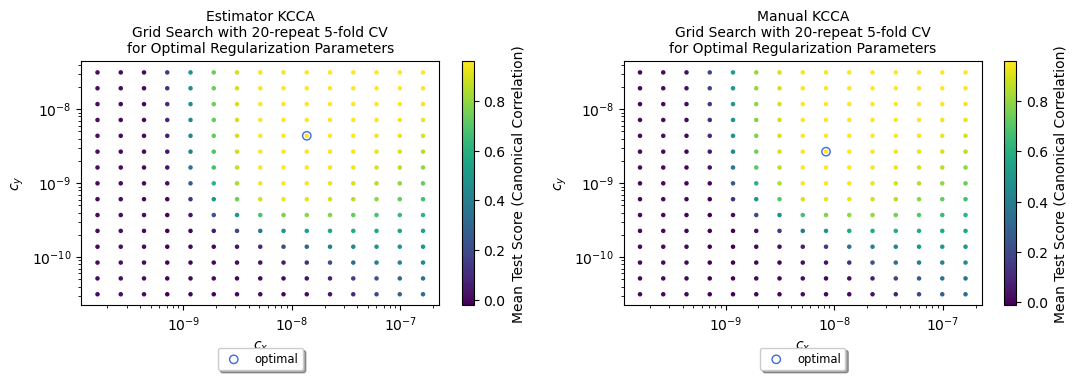

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(11, 4))

# draw grid search for estimator KCCA
viz_cxcy_search(
    fig, axes[0], estimator_kcca_bunch.viz_x, estimator_kcca_bunch.viz_y, 
    estimator_kcca_bunch.viz_color, n_repeats, n_splits, 
    estimator_kcca_bunch.c_x_opt, estimator_kcca_bunch.c_y_opt
)
axes[0].set_title('Estimator KCCA\n'+axes[0].title.get_text(), fontsize=10)
axes[0].set(xscale='log', yscale='log')

# draw grid search for manual KCCA
viz_cxcy_search(
    fig, axes[1], manual_kcca_bunch.viz_x, manual_kcca_bunch.viz_y, 
    manual_kcca_bunch.viz_color, n_repeats, n_splits, 
    manual_kcca_bunch.c_x_opt, manual_kcca_bunch.c_y_opt
)
axes[1].set_title('Manual KCCA\n'+axes[1].title.get_text(), fontsize=10)
axes[1].set(xscale='log', yscale='log')

fig.tight_layout()

print('The c_x optimal is {:.2e} and the c_y optimal is {:.2e}'.format(
    estimator_kcca_bunch.c_x_opt, 
    estimator_kcca_bunch.c_y_opt
))

Looks everything is good! 
Also the computational time is much shorter for utilizing the estimator.